# Visualizing the Parts of the Connectome that Predict Strategt

In [39]:
import nilearn.plotting as nip
import nilearn.image as nimg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

In [40]:
oldfont = plt.rcParams['font.sans-serif']
plt.rcParams['font.sans-serif'] = ['FreeSans']

## Load the Power 2011 classification

All of the connectomes in this analysis were extacted from the Power 2011 classification. We will start by first loading the corresponding data table.

In [41]:
power2011 = pd.read_csv("../bin/power_2011.csv")
power2011 = power2011.iloc[:,0:7]
power2011

,ROI,X,Y,Z,Network,Color,NetworkName
0,1,-25,-98,-12,-1,White,Uncertain
1,2,27,-97,-13,-1,White,Uncertain
2,3,24,32,-18,-1,White,Uncertain
3,4,-56,-45,-24,-1,White,Uncertain
4,5,8,41,-24,-1,White,Uncertain
...,...,...,...,...,...,...,...
259,260,-27,-71,37,12,Green,Dorsal attention
260,261,-32,-1,54,12,Green,Dorsal attention
261,262,-42,-60,-9,12,Green,Dorsal attention
262,263,-17,-59,64,12,Green,Dorsal attention


### Visualize the Brain Parcellation

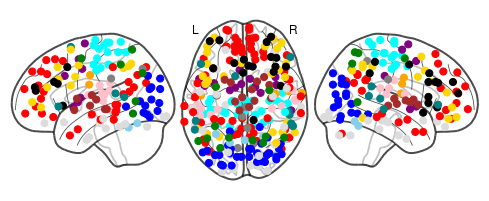

In [42]:
pc = np.zeros((264, 264))
pcol = [x.lower() for x in list(power2011['Color'])]

def colortranslate(x):
    if x.lower() == "yellow":
        return "gold"
    elif x.lower() == "pale blue":
        return "skyblue"
    elif x.lower() == "white":
        return "gainsboro"
    else:
        return x
    
pcol = [colortranslate(x) for x in pcol]
xyz = []
for roi in list(power2011['ROI']):
    entry = power2011.loc[power2011['ROI'] == roi]
    x = int(entry['X'])
    y = int(entry['Y'])
    z = int(entry['Z'])
    xyz.append((x,y,z))
pcoords = np.array(xyz)

img = nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzr')

/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


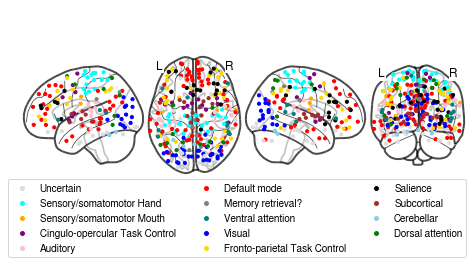

In [43]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
fig, axs = plt.subplots(1,1, figsize=(8,4))
nip.plot_connectome(pc, pcoords, node_color=pcol, display_mode='lzry', axes=axs, node_size=10)

allkols=list(power2011['Color'])
allnets=list(power2011['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=6) for x in [colortranslate(x) for x in kols]]

fig.legend(handles, nets, loc="lower center", ncol=3)
plt.savefig("figures/power2011.png", figsize=(8, 4), dpi=300)
plt.show()

## Visualize the Connectome Matrix

We can visualize the connectome matrix for the 62 participants. First, we load the data:

In [44]:
R = np.zeros((264, 264, 178))
PR = np.zeros((264, 264, 178))

index = 0
dpath = "../rsfmri/REST1/"
for subj in [x for x in os.listdir(dpath) if os.path.isdir(dpath + x)]:
    R[:,:,index] = pd.read_csv("%s/%s/ses-01/raw_corr_pearson.txt" % (dpath, subj,))
    PR[:,:,index] = pd.read_csv("%s/%s/ses-01/raw_pcorr.txt" % (dpath, subj,))
    index += 1        


Then, we visualize it as a matrix

In [45]:
# Calculate mean r values using Fisher's Z transform
mR = np.tanh(np.mean((np.log(1+R) - np.log(1-R))/2, 2))
mPR = np.tanh(np.mean((np.log(1+PR) - np.log(1-PR))/2, 2))


for ii in range(264):
    mR[ii,ii] = 0
    mPR[ii,ii] = 0

/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


## Visualizing the Average Connectome

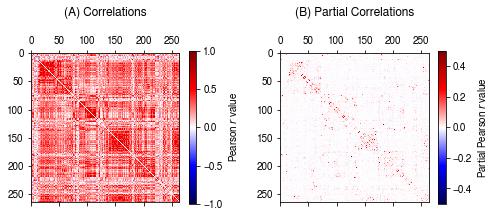

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = axs[0].matshow(mR, vmin=-1, vmax=1, cmap="seismic")
axs[0].set_title("(A) Correlations\n")
cbar = axs[0].figure.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel(r"Pearson $r$ value", rotation=90, va="top")

im = axs[1].matshow(mPR, vmin=-0.5, vmax=0.5, cmap="seismic")
axs[1].set_title("(B) Partial Correlations\n")
cbar = axs[1].figure.colorbar(im, ax=axs[1])
cbar.ax.set_ylabel(r"Partial Pearson $r$ value", rotation=90, va="top")

#axs[2].set_visible(False)
plt.tight_layout()
plt.savefig("figures/connectomes.png", dpi=300)


### Creating a generic function

Here we assemble all of the steps above into a single function.

In [47]:
### Create a Handy Function

def connectome_visualization(variable, name=None, blackbg=True):
    if name is None:
        name = variable
    # Load the data
    data = pd.read_csv("%s.csv" % (variable,))
    
    # Extract Regions
    ROIs = []

    for c in data['connection']:
        roi1, roi2 = c.split("-")

        if int(roi1) not in ROIs:
            ROIs.append(int(roi1))
        if int(roi2) not in ROIs:
            ROIs.append(int(roi2))
    ROIs.sort()

    # Extra ROI data
    sub = power2011[power2011['ROI'].isin( ROIs)]
    N = len(sub['ROI'])
    
    connectome = np.zeros((N, N))
    weighted_connectome = np.zeros((N, N))
    
    for c in range(N):
        for r in range(N):
            roi1 = ROIs[c]
            roi2 = ROIs[r]
            conn_name = "%d-%d" % (min(roi1, roi2), max(roi1, roi2))
            entry = data.loc[data['connection'] == conn_name]
            if len(entry) == 1:
                beta=float(entry['Beta'])
                connectome[c,r] = beta
                weighted_connectome[c,r] = beta * mPR[int(ROIs[c]-1), int(ROIs[r]-1)]
    
    plt.imshow(connectome)
    plt.title("Connectome (Beta values)")
    plt.show()

    xyz = []
    sub.loc[:,['X', 'Y', 'Z']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        x = int(entry['X'])
        y = int(entry['Y'])
        z = int(entry['Z'])
        xyz.append((x,y,z))
    coords = np.array(xyz)

    colors = []
    sub.loc[:,['Color']]
    for roi in ROIs:
        entry = sub.loc[sub['ROI'] == roi]
        #col = entry['Color']
        col = entry.iloc[0,5]
        colors.append(col.lower())

    # Replace the stupid "pale blue"
    
    colors = [x if x != "pale blue" else "dodgerblue" for x in colors ]
    nip.plot_connectome(connectome, coords, colorbar=True,
                    title=r"Predictors of %s" % (name,), 
                    black_bg=blackbg, node_color=colors)
    plt.savefig("%s.png" % (variable,))
    nip.show()

    nip.plot_connectome_strength(connectome, coords,
                                 title=r"Importance of ROIs in %s" % (name,))
    plt.savefig("%s_importance.png" % (variable,))
    nip.show()
    
    return connectome, coords, colors, weighted_connectome

## Decision Making Strategy

We use the new function to plot a different variable, the Rate of Forgetting $\alpha$.

Now some prettier visualizations

In [ ]:
c, nc, cols, wc = connectome_visualization("strategy", name=r"Rate of Forgetting $\alpha$", blackbg=False)
nip.view_connectome(c, nc, colorbar_fontsize=8)

## Prettier Visualizations
Some prettier visualizations. First, we need to get the network names and colors.

In [ ]:
alpha = pd.read_csv("strategy.csv")
alpha

Then, we define the list of network names and corresponding colors

In [ ]:
ROIs = []

FCvals = []
for conn in alpha['connection']:
    roi1, roi2 = conn.split("-")

    if int(roi1) not in ROIs:
        ROIs.append(int(roi1))
    if int(roi2) not in ROIs:
        ROIs.append(int(roi2))
        
    FCvals.append(mPR[int(roi1)-1, int(roi2)-1])
ROIs.sort()

pcol = [colortranslate(x) for x in pcol]

subset = pd.DataFrame(power2011[power2011['ROI'].isin(ROIs)])
print(subset.shape)
subset

Now, we use the `subset` to create the list of network names and corresponding colors

In [ ]:
allkols=list(subset['Color'])
allnets=list(subset['NetworkName'])

kols=[]
nets=[]
for i in range(len(allkols)):
    if not allkols[i] in kols:
        kols.append(allkols[i])
        nets.append(allnets[i])

handles = [Line2D([0], [0], marker='o', markerfacecolor=x, color="w", markersize=10) for x in [colortranslate(x) for x in kols]]

And now, we visualize that:

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(10, 4.2))

nip.plot_connectome(c, nc, [colortranslate(x) for x in cols], 
                    edge_cmap="seismic", 
                    #edge_cmap="viridis", 
                    axes=axs, node_size=12,
                    display_mode="lzry", colorbar=True, 
                    edge_vmax=10, edge_vmin=-10)

fig.legend(handles, nets, loc="lower center", ncol=3)
plt.savefig("figures/strategy_pretty.png", figsize=(10, 4.2), dpi=300)
plt.show()

## Node Importance

In [ ]:
importance = np.sum(np.abs(c), axis=1)
fig, axs = plt.subplots(1,1, figsize=(10, 2.5))
nip.plot_markers(node_values=importance, node_coords=nc, alpha=0.6, 
                 axes=axs, display_mode="lzry", node_cmap="plasma", node_vmin=-0, node_vmax=20)
plt.savefig("figures/strategy_importance.png", dpi=300)
plt.show()

## Personalized Node Importance

This follows a suggestion by Florian Sense.

In [ ]:
importance = np.sum(np.abs(c), axis=1)
size = np.power(importance, 2)
fig, axs = plt.subplots(2,1, figsize=(7, 4),
                       gridspec_kw={'height_ratios':(10,1)})

d = nip.plot_glass_brain(None, axes=axs[0], display_mode="ortho")
d.add_markers(nc, 
              marker_color=[colortranslate(x) for x in cols], 
              marker_size = 0.4*size)
#d.add_contours("episodic_memory_association-test_z_FDR_0.01.nii.gz", levels=[0], filled=True, colors="#FF000033")
#d.add_contours("memory_retrieval_association-test_z_FDR_0.01.nii.gz", levels=[0], filled=True, colors="#0000FF33")
#d.add_contours("autobiographical_memory_association-test_z_FDR_0.01.nii.gz", levels=[0], filled=True, colors="#00FF0033")
axs[1].axis('off')
axs[1].legend(handles, nets, loc="center", ncol=3)
fig.suptitle("Node Importance")
plt.savefig("figures/strategy_important_florian.png", dpi=300)

## Comparison to Task-Based Meta-Analytic Activations

Here we compare the distributions of ROIs to existing meta-analytic data from neurosynth 

### Results vs. Meta-Analysis of Both Episodic Memory and Memory Retrieval